Import Libraries

In [105]:
import time
start = time.perf_counter()

In [106]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OrdinalEncoder , StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
from sklearn.metrics import roc_auc_score,f1_score, precision_score, recall_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
from typing import Dict, Any, Literal
from pydantic import BaseModel, Field,ConfigDict
import uvicorn
from fastapi import FastAPI
import requests
import warnings
from sklearn.exceptions import ConvergenceWarning


In [107]:
print("Total import time:", time.perf_counter() - start)


Total import time: 0.6351140001788735


In [108]:
df = pd.read_csv('../data/train.csv')

In [109]:
df.shape

(593994, 13)

In [110]:
df['loan_paid_back'].value_counts()

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

In [111]:
df['loan_paid_back'].value_counts(normalize=True)*100

loan_paid_back
1.0    79.881952
0.0    20.118048
Name: proportion, dtype: float64

### 🧭 Previewing the Dataset
Displays the first few rows to understand structure and values.

In [112]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


### 🔍 Checking Data Types
Shows column types for preprocessing decisions.

In [113]:
df.dtypes

id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

### 🚫 Missing Values Analysis
Counts missing values to plan data cleaning.

In [114]:
df.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [115]:
df.drop_duplicates(inplace=True)


### 📈 Statistical Summary
Describes numerical columns to detect outliers and skew.

In [116]:
df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442236,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [117]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

<b> Bringing all columns in lowercase </b> 

In [118]:
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

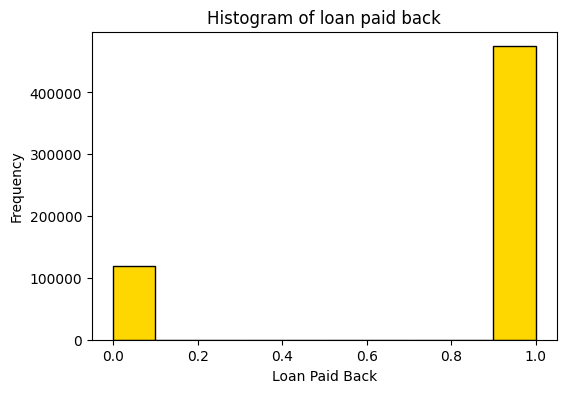

In [119]:
    plt.figure(figsize=(6,4))
    plt.hist(df['loan_paid_back'], bins=10, color='gold', edgecolor='black')
    plt.title(f'Histogram of loan paid back')
    plt.xlabel('Loan Paid Back')
    plt.ylabel('Frequency')
    plt.show()

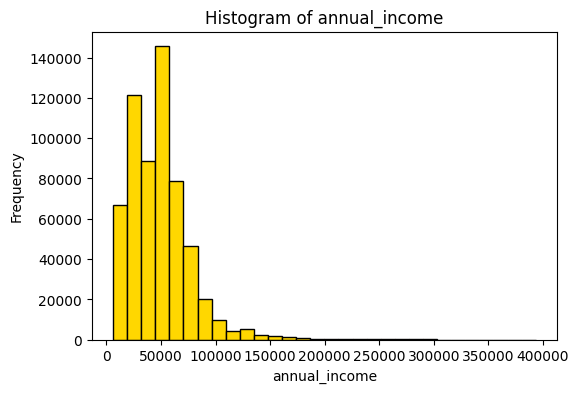

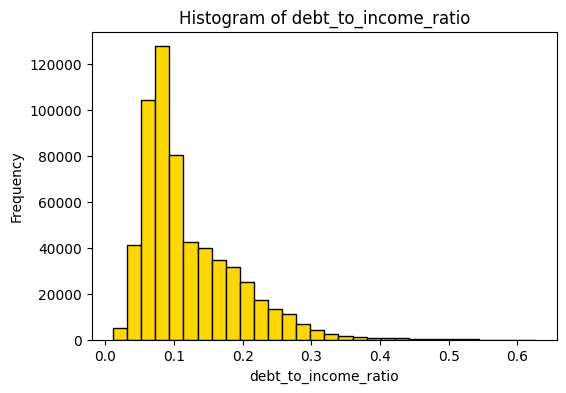

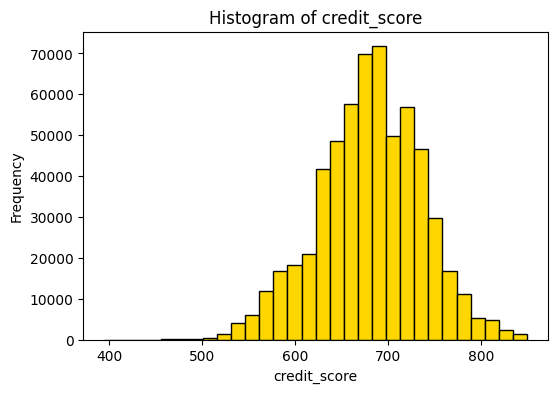

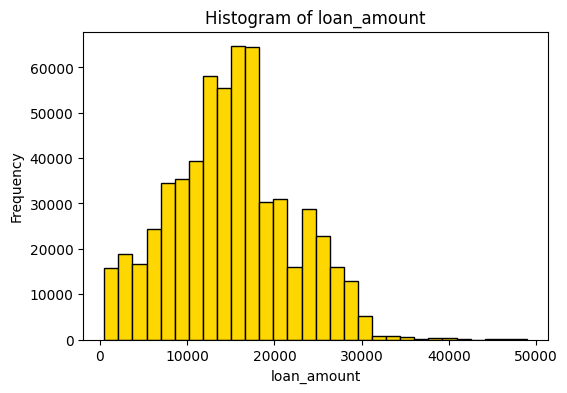

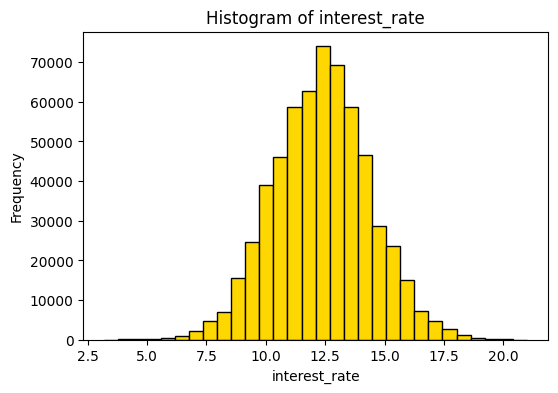

In [120]:
numerical_columns = [
 'annual_income',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'interest_rate'
]

for col in numerical_columns:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=30, color='gold', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [121]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,female,single,high_school,self-employed,other,c3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,male,married,master's,employed,debt_consolidation,d3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,male,single,high_school,employed,debt_consolidation,c5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,female,single,high_school,employed,debt_consolidation,f1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,male,married,high_school,employed,other,d1,1.0


<b> Checking Unique values in columns

In [122]:
df.nunique()


id                      593994
annual_income           119728
debt_to_income_ratio       526
credit_score               399
loan_amount             111570
interest_rate             1454
gender                       3
marital_status               4
education_level              5
employment_status            5
loan_purpose                 8
grade_subgrade              30
loan_paid_back               2
dtype: int64

<b> Shape of Dataset 

In [123]:
df.shape

(593994, 13)

## Exploratory Data Analysis

### <b> Analyzing categorical variables 

In [124]:
df_grouped = df.groupby('education_level')['education_level'].count()

df_grouped

education_level
bachelor's     279606
high_school    183592
master's        93097
other           26677
phd             11022
Name: education_level, dtype: int64

In [125]:
df_grouped = df.groupby('loan_purpose')['loan_purpose'].count()

df_grouped

loan_purpose
business               35303
car                    58108
debt_consolidation    324695
education              36641
home                   44118
medical                22806
other                  63874
vacation                8449
Name: loan_purpose, dtype: int64

In [126]:
df_grouped = df.groupby('grade_subgrade')['grade_subgrade'].count()

df_grouped

grade_subgrade
a1     1600
a2     2018
a3     2066
a4     1701
a5     2471
b1    14344
b2    15167
b3    13926
b4    13877
b5    13937
c1    53363
c2    54443
c3    58695
c4    55957
c5    53317
d1    37029
d2    34432
d3    36694
d4    35097
d5    32101
e1     6891
e2     6372
e3     7075
e4     8036
e5     6084
f1     5534
f2     5203
f3     5082
f4     5535
f5     5947
Name: grade_subgrade, dtype: int64

In [127]:
df_grouped = df.groupby('employment_status')['employment_status'].count()

df_grouped

employment_status
employed         450645
retired           16453
self-employed     52480
student           11931
unemployed        62485
Name: employment_status, dtype: int64

<b> Train Test Split . We will split the df_full_train further later on after we complete EDA, hence commented rest of code

In [128]:
##from sklearn.model_selection import train_test_split
##df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#df_train = df_train.reset_index(drop=True)
#df_val = df_val.reset_index(drop=True)
#df_test = df_test.reset_index(drop=True)
#y_train = df_train.loan_paid_back.values
#y_val = df_val.loan_paid_back.values
#y_test = df_test.loan_paid_back.values

#del df_train['loan_paid_back']
#del df_val['loan_paid_back']
#del df_test['loan_paid_back']

In [129]:
#len(df_train), len(df_val), len(df_test)


In [130]:
numerical_columns

['annual_income',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'interest_rate']

In [131]:
categorical_columns

['gender',
 'marital_status',
 'education_level',
 'employment_status',
 'loan_purpose',
 'grade_subgrade']

<b> Both Genders have paid back the loan equally, hence not very imp feature

In [132]:
df_grouped = df.groupby('gender')['loan_paid_back'].mean().sort_values(ascending=False)


df_grouped

gender
female    0.801708
male      0.795752
other     0.795333
Name: loan_paid_back, dtype: float64

<b> People irrespective of marital status have paid back loan, hence not important feature

In [133]:
df_grouped = df.groupby('marital_status')['loan_paid_back'].mean().sort_values(ascending=False)


df_grouped

marital_status
married     0.799144
single      0.798873
divorced    0.796640
widowed     0.789848
Name: loan_paid_back, dtype: float64

<b> Education Level has slight effect on loan paid back variable. We shall encode it later using Ordinal encoding

In [134]:
df_grouped = df.groupby('education_level')['loan_paid_back'].mean().sort_values(ascending=False)


df_grouped

education_level
phd            0.830067
high_school    0.809698
other          0.802789
master's       0.802346
bachelor's     0.788892
Name: loan_paid_back, dtype: float64

<b> Employment Status had major effect on loan paid back variable. Unemplopyed people mostly default on their loans

In [135]:
df_grouped = df.groupby('employment_status')['loan_paid_back'].mean().sort_values(ascending=False)


df_grouped

employment_status
retired          0.997204
self-employed    0.898457
employed         0.894145
student          0.263515
unemployed       0.077619
Name: loan_paid_back, dtype: float64

<b>Loan Purpose has not Slight effect on loan paid back variable hence not important feature. Medical and Education loans are riskier. We shall encode it later using Target encoding</b>

In [136]:
df_grouped = df.groupby('loan_purpose')['loan_paid_back'].mean().sort_values(ascending=False)

df_grouped

loan_purpose
home                  0.823224
business              0.813104
other                 0.802377
car                   0.800630
debt_consolidation    0.796911
vacation              0.796071
medical               0.778085
education             0.777053
Name: loan_paid_back, dtype: float64

<b> Grade Subgrade does have some effect on loan paid back variable. We shall encode this later using Ordinal encoding

In [137]:
df_grouped = df.groupby('grade_subgrade')['loan_paid_back'].mean()

df_grouped

grade_subgrade
a1    0.952500
a2    0.952924
a3    0.955470
a4    0.957084
a5    0.944962
b1    0.916341
b2    0.937430
b3    0.940040
b4    0.931758
b5    0.934204
c1    0.860090
c2    0.851165
c3    0.836000
c4    0.843987
c5    0.846259
d1    0.731886
d2    0.720957
d3    0.695972
d4    0.714733
d5    0.713000
e1    0.652010
e2    0.662743
e3    0.641837
e4    0.649577
e5    0.669461
f1    0.624503
f2    0.617721
f3    0.604093
f4    0.637037
f5    0.639314
Name: loan_paid_back, dtype: float64

<b> Global Loan Paid Back

In [138]:
global_loan_paid_back = df['loan_paid_back'].mean()

global_loan_paid_back

np.float64(0.7988195166954548)

<b> 79% of people have paid back the loan - higly imbalanced data set

<b> Finiding Risk Ratio on All Categorical variables </b> 

In [139]:
for c in categorical_columns:
    print(c)
    df_group = df.groupby(c).loan_paid_back.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_loan_paid_back 
    df_group['risk'] = df_group['mean'] / global_loan_paid_back 
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk
gender,,,,
female,0.801708,306175,0.002889,1.003616
male,0.795752,284091,-0.003067,0.996160
other,0.795333,3728,-0.003487,0.995635




marital_status


,mean,count,diff,risk
marital_status,,,,
divorced,0.796640,21312,-0.002179,0.997272
married,0.799144,277239,0.000325,1.000407
single,0.798873,288843,0.000054,1.000067
widowed,0.789848,6600,-0.008971,0.988770




education_level


,mean,count,diff,risk
education_level,,,,
bachelor's,0.788892,279606,-0.009927,0.987573
high_school,0.809698,183592,0.010878,1.013618
master's,0.802346,93097,0.003526,1.004415
other,0.802789,26677,0.003969,1.004969
phd,0.830067,11022,0.031248,1.039117




employment_status


,mean,count,diff,risk
employment_status,,,,
employed,0.894145,450645,0.095326,1.119333
retired,0.997204,16453,0.198385,1.248347
self-employed,0.898457,52480,0.099637,1.124730
student,0.263515,11931,-0.535304,0.329881
unemployed,0.077619,62485,-0.721201,0.097167




loan_purpose


,mean,count,diff,risk
loan_purpose,,,,
business,0.813104,35303,0.014284,1.017882
car,0.800630,58108,0.001810,1.002266
debt_consolidation,0.796911,324695,-0.001909,0.997611
education,0.777053,36641,-0.021766,0.972752
home,0.823224,44118,0.024405,1.030551
medical,0.778085,22806,-0.020735,0.974043
other,0.802377,63874,0.003557,1.004453
vacation,0.796071,8449,-0.002749,0.996559




grade_subgrade


,mean,count,diff,risk
grade_subgrade,,,,
a1,0.952500,1600,0.153680,1.192384
a2,0.952924,2018,0.154104,1.192915
a3,0.955470,2066,0.156650,1.196102
a4,0.957084,1701,0.158265,1.198123
a5,0.944962,2471,0.146142,1.182948
b1,0.916341,14344,0.117522,1.147119
b2,0.937430,15167,0.138610,1.173519
b3,0.940040,13926,0.141221,1.176787
b4,0.931758,13877,0.132938,1.166418


In [140]:
from sklearn.metrics import mutual_info_score


In [141]:


def mutual_info_churn_score(series):
    return mutual_info_score(series, df.loan_paid_back)



In [142]:
mi = df[categorical_columns].apply(mutual_info_churn_score)
print(mi.sort_values(ascending=False))


employment_status    0.175941
grade_subgrade       0.026769
loan_purpose         0.000331
education_level      0.000325
gender               0.000028
marital_status       0.000003
dtype: float64


In [143]:
print(mi.sort_values(ascending=False))

employment_status    0.175941
grade_subgrade       0.026769
loan_purpose         0.000331
education_level      0.000325
gender               0.000028
marital_status       0.000003
dtype: float64


### Analyzing the Numeric features

In [144]:
def analyzenumeric_cols(numerical_columns): 
    for n in numerical_columns:
        n_mean = df[n].mean()
        n_below_mean = df[df[n] <= n_mean].loan_paid_back.mean()
        n_above_mean = df[df[n] > n_mean].loan_paid_back.mean()
        print("For numeric column ", n, "loan paid back % below mean is ", n_below_mean)
        print("For numeric column ", n, "loan paid back % above mean is ", n_above_mean)

In [145]:
analyzenumeric_cols(numerical_columns)

For numeric column  annual_income loan paid back % below mean is  0.7959893065026828
For numeric column  annual_income loan paid back % above mean is  0.8020465518483822
For numeric column  debt_to_income_ratio loan paid back % below mean is  0.8815560317498535
For numeric column  debt_to_income_ratio loan paid back % above mean is  0.6583695509021467
For numeric column  credit_score loan paid back % below mean is  0.7152006638240308
For numeric column  credit_score loan paid back % above mean is  0.8768991864466372
For numeric column  loan_amount loan paid back % below mean is  0.8011790230472849
For numeric column  loan_amount loan paid back % above mean is  0.7964406097754758
For numeric column  interest_rate loan paid back % below mean is  0.8422936638147279
For numeric column  interest_rate loan paid back % above mean is  0.7559249473226529


In [146]:
#This is also corroborated by Correlation table
df[numerical_columns].corrwith(df.loan_paid_back).abs().sort_values(ascending=False)

debt_to_income_ratio    0.335680
credit_score            0.234560
interest_rate           0.131184
annual_income           0.006326
loan_amount             0.003762
dtype: float64

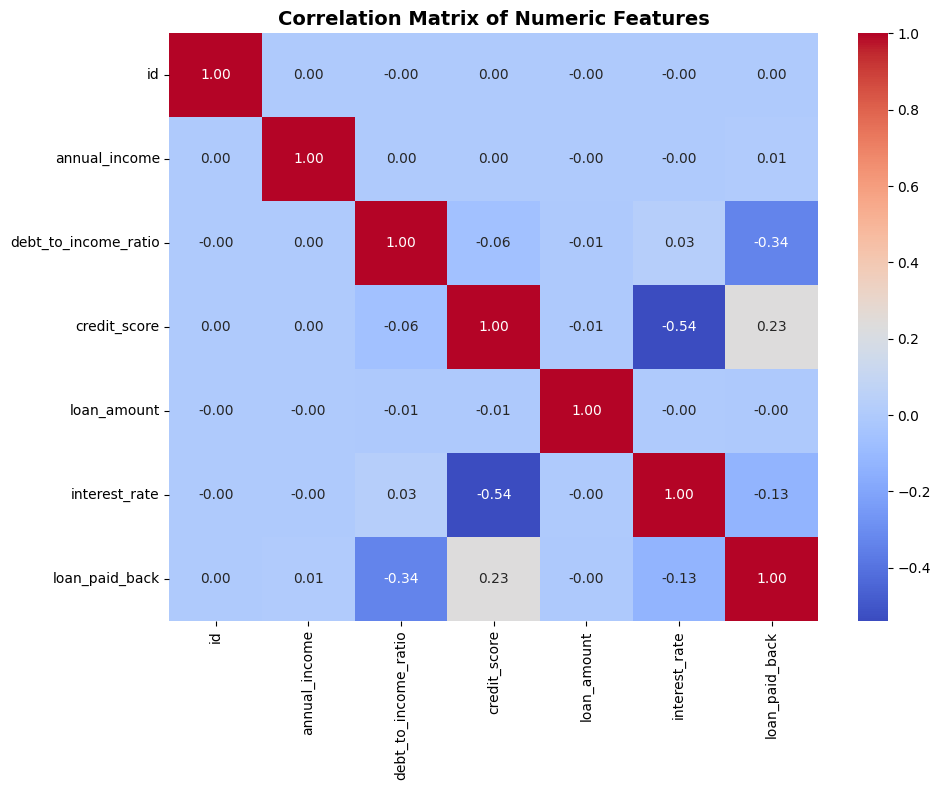

In [147]:
plt.figure(figsize=(10,8))
cor=df.corr(numeric_only=True)
sns.heatmap(cor, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix of Numeric Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../images/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

#### Key insights of analysis of numeric columns
-  It shows that higher credit score implies person will pay back loan and lower credit score implies person will not payback loan (positive correlation)
-  It shows that higher debt-to-income ratio implies person will not pay back loan and lower debt-to-income ratio implies person will payback loan (negative Correlation)
-  For lower interest_rate loan paid back percent is higher than higher interest rate (negative Correlation)
-  The other columns like Annual Income/Loan Amount does not really impact the Loan Pay Back intention

## Feature Engineering

### 🏷️ Dropping Non-Predictive Columns
Removes the id column as it adds no value.

In [148]:
df = df.drop('id' , axis = 1)

In [149]:
## As per mutual information score, gender and marital status are not strong features, hence dropping these columns from dataset

In [150]:
df = df.drop(['gender', 'marital_status'], axis = 1)

In [151]:
df['education_level'] = df['education_level'].replace("master's", "masters")

In [152]:
df['education_level'] = df['education_level'].replace("bachelor's", "bachelors")

In [153]:
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,high_school,self-employed,other,c3,1.0
1,22108.02,0.166,636,4593.10,12.92,masters,employed,debt_consolidation,d3,0.0
2,49566.20,0.097,694,17005.15,9.76,high_school,employed,debt_consolidation,c5,1.0
3,46858.25,0.065,533,4682.48,16.10,high_school,employed,debt_consolidation,f1,1.0
4,25496.70,0.053,665,12184.43,10.21,high_school,employed,other,d1,1.0


### Splitting dataset into train and test.

### We shall delete the target column once encoding is complete

In [154]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.loan_paid_back.values
y_val = df_val.loan_paid_back.values
y_test = df_test.loan_paid_back.values

#del df_train['loan_paid_back']
#del df_val['loan_paid_back']
#del df_test['loan_paid_back']

In [155]:
df_train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,60737.14,0.204,784,8243.98,9.97,high_school,employed,debt_consolidation,b5,1.0
1,52493.49,0.076,689,14924.53,13.91,masters,self-employed,debt_consolidation,c5,1.0
2,30887.15,0.079,611,2274.98,14.52,high_school,employed,debt_consolidation,d3,0.0
3,48362.84,0.053,715,25863.66,11.74,high_school,employed,debt_consolidation,c1,1.0
4,74599.93,0.152,563,9995.24,14.64,high_school,employed,home,f3,0.0


## Encoding Categorical variables using Ordinal Encoder. We will encode the training set and map onto test set

<b> Converting education level to numerical using Ordinal encoder


In [156]:
# Define the order of categories
edu_category_order = [['high_school', 'other', 'bachelors', 'masters', 'phd']]
edu_encoder = OrdinalEncoder(categories=edu_category_order)
df_train['education_encoded'] = edu_encoder.fit_transform(df_train[['education_level']])
df_val['education_encoded'] = edu_encoder.transform(df_val[['education_level']])
df_test['education_encoded'] = edu_encoder.transform(df_test[['education_level']])

df_train = df_train.drop(['education_level'], axis=1)
df_val = df_val.drop(['education_level'], axis=1)
df_test = df_test.drop(['education_level'], axis=1)
#print(df_full_train.head())

<b> Converting grade_subgrade to numerical using Ordinal encoder

In [157]:
grade_category_order = [['f5', 'f4', 'f3', 'f2', 'f1', 'e5', 'e4','e3','e2','e1', 'd5', 'd4','d3','d2','d1', 'c5', 'c4','c3','c2','c1', 'b5', 'b4','b3','b2','b1',  'a5', 'a4','a3','a2','a1']]
grade_encoder = OrdinalEncoder(categories=grade_category_order)
df_train['grade_code'] = grade_encoder.fit_transform(df_train[['grade_subgrade']])
df_train  = df_train.drop(['grade_subgrade'], axis = 1)
df_val['grade_code'] = grade_encoder.transform(df_val[['grade_subgrade']])
df_val  = df_val.drop(['grade_subgrade'], axis = 1)
df_test['grade_code'] = grade_encoder.transform(df_test[['grade_subgrade']])
df_test  = df_test.drop(['grade_subgrade'], axis = 1)



<b> Converting loan purpose into numeric using Target encoding

In [158]:
purpose_te = (
    df_train
    .groupby('loan_purpose')['loan_paid_back']
    .mean()
)

purpose_te

loan_purpose
business              0.811208
car                   0.799983
debt_consolidation    0.796622
education             0.778142
home                  0.821691
medical               0.775408
other                 0.801909
vacation              0.796453
Name: loan_paid_back, dtype: float64

In [159]:


df_train['loan_purpose_te'] = df_train['loan_purpose'].map(purpose_te)
df_test['loan_purpose_te'] = df_test['loan_purpose'].map(purpose_te)
df_val['loan_purpose_te'] = df_val['loan_purpose'].map(purpose_te)

global_mean = df_train['loan_paid_back'].mean()
df_test['loan_purpose_te'] = df_test['loan_purpose_te'].fillna(global_mean)
df_val['loan_purpose_te'] = df_val['loan_purpose_te'].fillna(global_mean)

df_train = df_train.drop('loan_purpose', axis=1)
df_val = df_val.drop('loan_purpose', axis=1)
df_test = df_test.drop('loan_purpose', axis=1)

In [160]:
del df_train['loan_paid_back']
del df_val['loan_paid_back']
del df_test['loan_paid_back']

In [161]:
if 'loan_paid_back' in numerical_columns:
    numerical_columns.remove('loan_paid_back')

In [162]:
df_train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,employment_status,education_encoded,grade_code,loan_purpose_te
0,60737.14,0.204,784,8243.98,9.97,employed,0.0,20.0,0.796622
1,52493.49,0.076,689,14924.53,13.91,self-employed,3.0,15.0,0.796622
2,30887.15,0.079,611,2274.98,14.52,employed,0.0,12.0,0.796622
3,48362.84,0.053,715,25863.66,11.74,employed,0.0,19.0,0.796622
4,74599.93,0.152,563,9995.24,14.64,employed,0.0,2.0,0.821691


In [163]:
categorical_columns = list(df_train.dtypes[df_train.dtypes == 'object'].index)

categorical_columns

['employment_status']

In [164]:
numerical_columns = list(df_train.dtypes[df_train.dtypes != 'object'].index)

numerical_columns

['annual_income',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'interest_rate',
 'education_encoded',
 'grade_code',
 'loan_purpose_te']

In [165]:
warnings.filterwarnings(
    "ignore",
    category=ConvergenceWarning
)

In [166]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
scaler = StandardScaler()

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_train_scaled = scaler.fit_transform(X_train)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val_scaled = scaler.transform(X_val)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)
X_test_scaled = scaler.transform(X_test)




## Logistic Regression Model

### Tuning Logistic Regression model for various Regularization (C) parameters

In [167]:
log_scores = []
for reg in [0.01, 0.1, 1, 10, 100]:
        log_model = LogisticRegression(solver='lbfgs', C= reg, max_iter=1000, random_state=42)
        # solver='lbfgs' is the default solver in newer version of sklearn
        # for older versions, you need to specify it explicitly
        log_model.fit(X_train_scaled, y_train)
        log_model.intercept_[0]
        log_model.coef_[0].round(3)
        y_pred = log_model.predict_proba(X_val_scaled)[:, 1]
        loan_decision = (y_pred >= 0.5)
         ###  accuracy = (y_val == loan_decision).mean()
        log_scores.append({
        "C": reg,
        "Accuracy": accuracy_score(y_val, loan_decision),
        "AUC Score": roc_auc_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, loan_decision)
         })
        

In [168]:
log_scores_df = pd.DataFrame(log_scores)
log_scores_df

,C,Accuracy,AUC Score,F1 Score
0,0.01,0.900437,0.909736,0.940023
1,0.10,0.900487,0.909736,0.940046
2,1.00,0.900428,0.909741,0.940009
3,10.00,0.900428,0.909741,0.940009
4,100.00,0.900428,0.909741,0.940009


### Best Auc Score s acheived for C=1, 10 and 100. Since dataset is imbalanced, we are giving preference to AUC Score for evaluation

### Final Logistic Regression Model is based on C = 1

In [169]:
final_log_model = LogisticRegression(solver='lbfgs' ,C= 1, max_iter=1000, random_state=42)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
final_log_model.fit(X_train_scaled, y_train)
final_log_model.intercept_[0]
final_log_model.coef_[0].round(3)
y_pred = final_log_model.predict_proba(X_val_scaled)[:, 1]


In [170]:
## Checking for best threshold on the fonal model

In [2]:
thresholds= np.linspace(0,1,21).round(2)
acc_scores = []
#print("threshold | accuracy score")
for t in thresholds:
    loan_decision = (y_pred >=t)
   ### score = (y_val == loan_decision).mean()*100
    acc_scores.append(
    {
        "Threshold": t,
        "Accuracy": accuracy_score(y_val, loan_decision),
        "AUC Score": roc_auc_score(y_val, y_pred),
        "F1 Score" : f1_score(y_val,loan_decision)
         }
    )


NameError: name 'np' is not defined

In [172]:
t_scores = pd.DataFrame(acc_scores)
t_scores

,Threshold,Accuracy,AUC Score,F1 Score
0,0.00,0.801025,0.909741,0.889521
1,0.05,0.855327,0.909741,0.917124
2,0.10,0.880336,0.909741,0.930367
3,0.15,0.892491,0.909741,0.936882
4,0.20,0.897811,0.909741,0.939672
5,0.25,0.899705,0.909741,0.940571
6,0.30,0.900765,0.909741,0.940996
7,0.35,0.901321,0.909741,0.941156
8,0.40,0.901641,0.909741,0.941174
9,0.45,0.901363,0.909741,0.940807


<b> The best F1 Score is acheived at threshold = 0.4, hence we will consider 0.4 as threshold . <br> LogisticRegression Model is giving Accuracy of 90.16%, roc_auc_score of 0.909741 and F1_Score= 0.941174 on validation set. 

<b> LogisticRegression Model is giving Accuracy of 90.04% , roc_auc_score of 0.90989 and F1 Score of 0.9402307451186588 on test set at threshold t = 0.4

In [173]:
y_pred = final_log_model.predict_proba(X_test_scaled)[:, 1]
y_pred_prob = (y_pred >= 0.4).astype(int)
auc_test_log  = roc_auc_score(y_test, y_pred)
print('Auc Score on Test Set' , auc_test_log)
f1_score_test = f1_score(y_test, y_pred_prob)
acc_test = accuracy_score(y_test,y_pred_prob)
print('F1 score on test set', f1_score_test)
print('Accuracy on Test set',acc_test )

Auc Score on Test Set 0.9098908451463953
F1 score on test set 0.9402307451186588
Accuracy on Test set 0.9004873778398808


## Decision Tree 

<B> Using Decision Tree best AUC is acheived at depth = 10

In [174]:

depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.734
   2 -> 0.832
   3 -> 0.854
   4 -> 0.889
   5 -> 0.901
   6 -> 0.906
  10 -> 0.909
  15 -> 0.882
  20 -> 0.827
None -> 0.770


<B> Trying to determine best min_samples_leaf at depths 5,6,10

In [175]:
scores = []
for d in [5,6,10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [176]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [177]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot

auc                    
max_depth               5         6         10
min_samples_leaf                              
1                 0.900763  0.906093  0.909384
5                 0.900763  0.906127  0.912096
10                0.900763  0.906118  0.913001
15                0.900763  0.906119  0.913329
20                0.900763  0.906116  0.913592
100               0.900765  0.906101  0.914151
200               0.900759  0.905977  0.913689
500               0.900795  0.905597  0.912862

<b> lets consider min_sample_leaves = 100 and max_depth = 10 as final parameters for the decision tree as we are getting best AUC = 0.914151

### Final Decision Tree is created with min_sample_leaves = 100 and max_depth = 10

In [180]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)


In [181]:
thresholds = np.arange(0.1, 1, 0.05)
decision_threshold_metrics = []

for t in thresholds:
    loan_decision = (y_pred >= t).astype(int)

    f1 = f1_score(y_val, loan_decision)
    acc =  accuracy_score(y_val, loan_decision)
    decision_threshold_metrics.append([t, f1, auc,acc])

df_decision_thresholds = pd.DataFrame(
    decision_threshold_metrics, 
    columns=["Threshold", "F1", "ROC-AUC", "Accuracy"]
)

print(df_decision_thresholds)

    Threshold        F1   ROC-AUC  Accuracy
0        0.10  0.935141  0.914151  0.889166
1        0.15  0.937874  0.914151  0.894250
2        0.20  0.939227  0.914151  0.896784
3        0.25  0.939902  0.914151  0.898088
4        0.30  0.940658  0.914151  0.899578
5        0.35  0.941097  0.914151  0.900462
6        0.40  0.941701  0.914151  0.901918
7        0.45  0.941549  0.914151  0.901767
8        0.50  0.941478  0.914151  0.902491
9        0.55  0.940598  0.914151  0.901758
10       0.60  0.939566  0.914151  0.900563
11       0.65  0.934912  0.914151  0.894477
12       0.70  0.928872  0.914151  0.886279
13       0.75  0.920156  0.914151  0.874418
14       0.80  0.908515  0.914151  0.858627
15       0.85  0.893692  0.914151  0.839031
16       0.90  0.827396  0.914151  0.757742
17       0.95  0.624945  0.914151  0.559399


<b> Best F1 Score is acheived at threshold = 0.4 on the validation set<br>
Accuracy = 0.901918 <br>
F1 Score = 0.941701    <br>
ROC AUC Score = 0.91415  


### Testing the Decision Tree Model on the test set with threshold = 0.5

In [182]:
y_pred = dt.predict_proba(X_test)[:, 1]
loan_decision = ((y_pred >= 0.4).astype(int))
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, loan_decision)
accuracy = accuracy_score(y_test, loan_decision)
print("Auc on Test Set is", auc)
print("F1 score on test set is", f1score)
print("Accuracy on test set is is", accuracy)

Auc on Test Set is 0.9131733505743798
F1 score on test set is 0.9413282724826284
Accuracy on test set is is 0.901632168620948


## Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [84]:
n_estimators = [100, 200, 300]
max_features = ['sqrt', 'log2']
max_depth = [5, 6, 10]
min_samples_leaf = [20, 100, 200]

params_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

model_cv = GridSearchCV(
    estimator=model_rf,
    param_grid=params_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

model_cv.fit(X_train, y_train)

print("Best Parameters:", model_cv.best_params_)

best_model = model_cv.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\mepri\LoanPayBack_Project\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 300}


In [93]:
pred = model_cv.predict_proba(X_val)[:, 1]

In [94]:
auc = roc_auc_score(y_val, pred)
print('Best Parameters for Random Forest Best Parameters: max_depth: 10, max_features: sqrt, min_samples_leaf: 20, n_estimators: 300')

print('ROC AUC Score on Random Forest Classifier with Best Parameters is ',auc)

Best Parameters for Random Forest Best Parameters: max_depth: 10, max_features: sqrt, min_samples_leaf: 20, n_estimators: 300
ROC AUC Score on Random Forest Classifier with Best Parameters is  0.9128053758891712


In [95]:
thresholds = np.arange(0.1, 1, 0.05)
rf_threshold_metrics = []

for t in thresholds:
    loan_decision = (pred >= t).astype(int)

    f1 = f1_score(y_val, loan_decision)
    acc =  accuracy_score(y_val, loan_decision)
    rf_threshold_metrics.append([t, f1, auc,acc])

rf_threshold_metrics = pd.DataFrame(
    rf_threshold_metrics, 
    columns=["Threshold", "F1", "ROC-AUC", "Accuracy"]
)

print(rf_threshold_metrics)

    Threshold        F1   ROC-AUC  Accuracy
0        0.10  0.932725  0.912805  0.884662
1        0.15  0.935981  0.912805  0.890706
2        0.20  0.939170  0.912805  0.896666
3        0.25  0.940357  0.912805  0.898905
4        0.30  0.940756  0.912805  0.899721
5        0.35  0.940942  0.912805  0.900168
6        0.40  0.941063  0.912805  0.900496
7        0.45  0.941231  0.912805  0.900942
8        0.50  0.941578  0.912805  0.901859
9        0.55  0.941708  0.912805  0.902701
10       0.60  0.940270  0.912805  0.901363
11       0.65  0.936505  0.912805  0.896590
12       0.70  0.931323  0.912805  0.889536
13       0.75  0.925946  0.912805  0.882162
14       0.80  0.913835  0.912805  0.865773
15       0.85  0.885507  0.912805  0.828298
16       0.90  0.792452  0.912805  0.718373
17       0.95  0.636326  0.912805  0.568835


<b> We are achieving best F1 Score with Randon Forest at threshold = 0.55 on the validation set <br>
Accuracy = 0.902701 <br>
F1 Score = 0.941708      <br>
ROC AUC Score = 0.912805    


In [205]:
pred = best_model.predict_proba(X_test)[:, 1]
loan_decision = ((pred >= 0.55).astype(int))
auc = roc_auc_score(y_test, pred)
f1score = f1_score(y_test, loan_decision)
accuracy = accuracy_score(y_test, loan_decision)
print("Auc on Test Set is", auc)
print("F1 score on test set is", f1score)
print("Accuracy on test set is is", accuracy)

Auc on Test Set is 0.912972215418096
F1 score on test set is 0.9412122009738912
Accuracy on test set is is 0.9022382343285718


<b> When we run Best Random Forest Classifier model on test set, following are the metrics<br>
<br> Accuracy = 0.90223
<br> F1 Score = 0.94121
<br> ROC_AUC = 0.912972   

## XGBoost Classifier

In [96]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [171]:
!pip install xgboost

In [97]:
import xgboost as xgb

In [98]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [195]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "max_depth": [ 5, 6,10,15,20],
    "min_child_weight": [1, 6,10,30],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [450, 500, 550],  
}
search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=params,
    n_iter=42,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)
search.fit(X_train, y_train)
print("Best Parameters", search.best_params_)



Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best Parameters {'n_estimators': 450, 'min_child_weight': 30, 'max_depth': 6, 'learning_rate': 0.1}


In [196]:
roc_auc_score(y_val, search.predict_proba(X_val)[:, 1])

0.9215192295993373

### Final XGB Model

In [198]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    tree_method='hist', 

    # Tuned parameters
    n_estimators=450,
    min_child_weight=30,
    max_depth=6,
    learning_rate=0.1,
)

# Fit model
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [201]:
y_val_prob = xgb_model.predict_proba(X_val)[:, 1]

In [202]:
thresholds = np.arange(0.1, 1, 0.05)
xgb_threshold_metrics = []

# ROC-AUC is threshold-independent
auc = roc_auc_score(y_val, y_val_prob)

for t in thresholds:
    loan_decision = (y_val_prob >= t).astype(int)
    f1 = f1_score(y_val, loan_decision)
    acc =  accuracy_score(y_val, loan_decision)
    xgb_threshold_metrics.append([t, f1, auc,acc])


df_xgb_threshold_metrics = pd.DataFrame(
xgb_threshold_metrics, 
columns=["Threshold", "F1", "ROC-AUC", "Accuracy"])

print(df_xgb_threshold_metrics)

    Threshold        F1   ROC-AUC  Accuracy
0        0.10  0.936129  0.921519  0.890942
1        0.15  0.938427  0.921519  0.895218
2        0.20  0.939693  0.921519  0.897617
3        0.25  0.940671  0.921519  0.899486
4        0.30  0.941450  0.921519  0.901009
5        0.35  0.942245  0.921519  0.902600
6        0.40  0.942635  0.921519  0.903602
7        0.45  0.943001  0.921519  0.904688
8        0.50  0.942831  0.921519  0.904999
9        0.55  0.942030  0.921519  0.904343
10       0.60  0.940330  0.921519  0.902314
11       0.65  0.937670  0.921519  0.898913
12       0.70  0.933622  0.921519  0.893543
13       0.75  0.926709  0.921519  0.884056
14       0.80  0.913108  0.921519  0.865369
15       0.85  0.886343  0.921519  0.830133
16       0.90  0.828367  0.921519  0.759552
17       0.95  0.689685  0.921519  0.616663


<b>We are achieving best F1 Score with XG Boost Model at threshold = 0.45 on the validation set<br>
Accuracy = 0.904688<br>
F1 Score = 0.943001<br>
ROC AUC Score = 0.921519

In [206]:
y_pred = xgb_model.predict_proba(X_test)[:, 1]
loan_decision = ((y_pred >= 0.45).astype(int))
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, loan_decision)
accuracy = accuracy_score(y_test, loan_decision)
print("Auc on Test Set is", auc)
print("F1 score on test set is", f1score)
print("Accuracy on test set is is", accuracy)

Auc on Test Set is 0.9211971205469955
F1 score on test set is 0.942529200177828
Accuracy on test set is is 0.9042416181954394


<b>Evalution of XG Boost on Test Set<br>
Accuracy = 0.90424<br>
F1 Score = 0.94252<br>
ROC AUC Score = 0.921197

In [204]:
#watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
#%%capture output

#xgb_params = {
 #   'eta': 0.2, 
  #  'max_depth': 6,
   # 'min_child_weight': 30,
    
    #'objective': 'binary:logistic',
    #'eval_metric': 'auc',

    #'nthread': 8,
    #'seed': 1,
    #'verbosity': 1,
#}

#xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=201,
 #                 verbose_eval=5,
  #                evals=watchlist)

In [ ]:
#s = output.stdout

In [ ]:
#df_score = parse_xgb_output(output)

In [ ]:
#df_score

In [ ]:
##best Auc is acheoved at iteration number 200

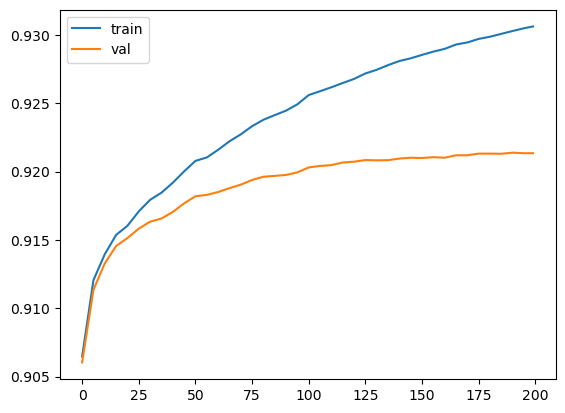

In [183]:
#plt.plot(df_score.num_iter, df_score.train_auc, label='train')
#plt.plot(df_score.num_iter, df_score.val_auc, label='val')
#plt.legend()
#plt.show()

In [185]:
test_pred = xgb_model.predict(dtest)

In [181]:
test_pred

array([0.8903159 , 0.0058043 , 0.9585007 , ..., 0.9349672 , 0.99087334,
       0.9817587 ], dtype=float32)

In [182]:
roc_auc_score(y_test, test_pred)

np.float64(0.9210320425561647)

In [ ]:
##So considering the final model as XGB Boost

In [ ]:
#Saving the model